## DSC170, Mini-Project 4: Raster Analysis on Fast Food Restaurants Locations

#### This project will focus on __suitability analysis__ with raster data. Your tasks will be both conceptual-level and technical. 

There are three parts to this assignment.

1. At the conceptual level, you will define a suitability model of your choice, for an area of your choice (preferably San Diego, because we already have worked with some local data). Consult the lectures on map combination, and also see https://en.wikipedia.org/wiki/Suitability_model for a brief description of what a suitability model is. For example, you may be looking for best areas for community gardens. Such areas are often selected from underutilized land in residential land uses, with good soils, good drainage, accessible (not steep slope), etc. So you would be looking for areas with a specific type of land use/land cover, with an appropriate range of values of slope, etc. You may build additional criteria based on a range of precipitaiton values, whether the area is affected by wildfires, or has low levels of soil erosion, etc. Feel free to use the imagery layers we explored or mentioned during raster-focused lectures. One of the cells contained a list of about a dozen such layers available through AGOL - but feel free to find more. Also, feel free to download additional raster layers from elsewhere (an example in lecture demonstrates how to do this from the USGS image repository.)  You can use any __two__ of the map combination techniques discussed during lectures. You should identify the ones you use, and discuss any uncertainty issues associated with these specific map combination models. 

As the outcome of this part, you will need to: a) describe the suitability model you want to develop; b) identify the raster data layers you will use; and c) describe two of the map combination techniques you will use to derive the two suitablity maps, and their pros and cons.

2. The second part will involve implementing your suitability model using arcgis raster functions. Many of these functions are new and experimental! Examples of what works are in the lecture notebooks. Be creative! But also note that the functions are associated with raster services and depend on the version of the server a particular imagery layer is served from. See in the lecture notebooks how you can retrieve the version of the API supported by each layer, and which functions are supported in each API. 

3. The third part will be a brief write-up comparing the two output rasters generated for the suitability models using the two map combination techniques. 

## 1. Formulate a suitability model 

#### Suitability Model

In our model we want to combine traffic density, population density, and land use, to assess area suitability for drive through fast-food restaurants. Our project could be useful for businesses that are looking to open new drive through locations. In this project, we want to find cells with high traffic density, high population density, and high intensity developed areas to place drive throughs in that general vicinity. Below is an equation of how we'll determine the suitability score:

Suitability score == F(traffic_density, population_density, land_use)

We used these variables because according to [Small Business Chron](https://smallbusiness.chron.com/things-consider-before-opening-fast-food-restaurant-17437.html), "If your fast food restaurant is located in a place with little traffic and visibility, your business most likely will not be successful. Fast food owners usually locate their restaurants by highways, business streets and shopping centers and close to other fast food restaurants. Malls, colleges and universities are also a good option for location." With this information, we know that we want to locate our drive through fast food restaurant near areas with high traffic density. We also know that we want to place our restaurant in an optimal location where there is a larger number of people. Lastly, we also want to place our restaurants in developed areas, given that the optimal locations that Small Business Chron suggested were in locations that tend to be more developed and have more impervious land. 

We'll be trying two types of mapping combinations in this project: exclusionary screening and linear combination. As an exploratory combination, we'll also try weighting and rating. A better explanation of the two is located below. 


In [5]:
# 2. Imports, etc.

from arcgis.geocoding import geocode
from arcgis import GIS
from arcgis.raster import *
from arcgis.geometry import *
%matplotlib inline
import pandas as pd
import numpy as np

# Importing graphviz would be useful as we trace layer operations
import graphviz

gis = GIS('https://gis-portal.ucsd.edu/portal', 'srpatel@ad')

Enter password: ········


In [6]:
agol = GIS(username='rherlim_dsc170fa20')
arcgis.raster.analytics.is_supported(gis)

Enter password: ········


True

In [11]:
# 3. List imagery layers to be used in your model. This cell should contian layer definitions.

usa_roads = ImageryLayer('https://gis-portal.usc.edu/arcgis/rest/services/AirPollution_TrafficDensity/TrafficDensity_Yr2014_10m/ImageServer',agol)
populations_layer = ImageryLayer('https://landscape7.arcgis.com/arcgis/rest/services/World_Population_Estimated_Density_2015/ImageServer', agol)
usa_land_use = ImageryLayer('https://landscape10.arcgis.com/arcgis/rest/services/USA_NLCD_Land_Cover/ImageServer', agol)


#### Imagery Layer Descriptions

1. *USA Roads*: This layer represents the annual average vehicles per day for 2014. This is the definition of traffic density as described by Sonoma Technology, the company who developed this layer. We chose this layer because it's the most recently developed year and because we want to place a drive through restaurant close to roads that have a high traffic density. The downsides to only using this layer is that we are only taking into account the roads themselves rather than placing our drive throughs in areas with pit stops or land available to actually build a drive through. For example, we can't build a drive through near a freeway, but rather we would build it at the nearest exit off the freeway. We'll take this into account with the USA land use layer, to try to develop our drive throughs in highly developed areas where most people work or live. 

2. *Populations*: This layer is a global estimate of human population density for 2015. We used the year 2015 since it was the closest to our 2014 USA Roads layer. We want to place our restaurants where there is a high population so that we can attract many customers. 

3. *USA Land Use*: This land use layer describes the surface of the earth. This time-enabled service of the National Land Cover Database groups land cover into 20 classes based on a modified Anderson Level II classification system. Classes include vegetation type, development density, and agricultural use. Areas of water, ice and snow and barren lands are also identified. For more information on the legend please follow this [link](https://ucsdonline.maps.arcgis.com/home/item.html?id=3ccf118ed80748909eb85c6d262b426f). For this project, we specifically wanted to put importance on finding developed areas in San Diego. This means that there are some amounts of impervious land that our drive through restaurants can be built on. The metadata also indicates that the developed area variables include housing to residents. So if we were to build restaurants near peoples' houses, then they'd be more likely to go through a drive through since it's in close proximity to their housing. 

In [12]:
# 4. Derive the area of interest (AOI) and its geometry and extent. 
# The smaller the area the better (so that you don't run into raster size limitations)

# Access the USA Counties item from the Living Atlas
counties_item = agol.content.search('USA Counties generalized', 'Feature Layer', outside_org=True)[1]

# Select San Diego County:
counties_lyr = counties_item.layers[0]
study_area_query = counties_lyr.query("FIPS='06073'", return_geometry=True)

# Get the geometry of the San Diego County feature.
# We will use this geometry to extract the input data for the study area.
study_area_geom = study_area_query.features[0].geometry
study_area_geom['spatialReference'] = study_area_query.spatial_reference

study_area_ex = Geometry(study_area_geom).geoextent  # or just 'extent'

# then create the extent as a dict from the returned tuple 

tup = (('xmin',study_area_ex[0]), ('ymin', study_area_ex[1]), ('xmax',study_area_ex[2]), ('ymax', study_area_ex[3]))
study_area_extent = dict(tup)

# to be correcter, let's also add CRS:
crs = "{'latestwkid':3857, 'wkid':102100}"
study_area_extent.update({'spatialReference':{'latestwkid':3857, 'wkid':102100}})

In [13]:
# 5. Name the two map combination techniques you will use to combine the data and describe their pros and cons (markdown)


#### <span style="background-color: #FFFF00">1. Exclusionary Screening</span> 
Our first mapping combination that we're going to use is exclusionary screening. Being a dominance rule, exclusionary screening selects one value from the available set and ignores the other values. In our model, we are going to use exclusionary screening in order to only get the most optimal locations for drive throughs. 

Similar to what was done in the Raster3_suitability_map_combination notebook, we will be taking an a * b * c approach between our binary layers. This is because if any values in the three binary raster layers is 0, then the final grid will output zero no matter what the other two raster values are. 

Some upsides to this form of combining maps is that it finds perfect locations based on the three imagery layers we binarized. For us, it'll find locations that fit all three criteria: (1) has high traffic density, (2) has high population density, and (3) have high intensity developed areas. 

Some downsides to exclusionary screening is that this form of map combination can exclude good locations that don't necessarily fit all of the criteria. It may be too strict at times and could condense the amount of good drive through locations that we could have otherwise placed in a certain area. 

#### <span style="background-color: #FFFF00">2. Linear Combination</span> 
Our second mapping combination that we'll try is linear combination. This is a contributory rule that takes into factor the values of each layer equally by adding up the values and ranks them by the summed value. We chose this method to create our map combination because through this approach we can equally consider all the factors that go into deciding the drive through location to simplify our problem. 

Some upsides to this approach is that we can save time by easily assessing the values for each cell by just looking at the sum, and there are no complicated calculations being done therefore we can easily interpret the results. We also do not have to deal with arithmetic errors such as multiplying by 0's that can be a problem with other Raster mapping combination.

Some downside to linear combination is that perhaps one layer could be too big of a factor to the mapping combination and potentially dominate the deciding factor for the mapping combination. Another downside is that we are limited in terms of customizing the arithmetic function to only summing, we can not assign weights to different layer values, therefore not getting the most accurate results that we want that could be achieved with other more complex mapping combination.

#### <span style="background-color: #FFFF00">3. Weighting and Rating</span> 

<span style = "color:red">** We decided to do a third mapping combination just to check it out. Since we weren't sure how to determine, we wanted to just experiment rather than have this be considered one of our official models.  **</span> 

Our third mapping combination that we'll try is weighting and rating. Being a contributory rule, weighting and rating factor maps composed of rankings/weights. These weights are externally assigned through techniques such as Delphi techniques or binary comparisons. In our model, we'll assign weights ourselves based on research that we did that will help us decide which factors are more important than others. 

Our weights will look like this:

- Traffic Density : 40%
- Population Density: 40%
- Land Use: 20%

We came up with these values by using this sources: https://www.fsrmagazine.com/expert-takes/8-factors-choosing-new-restaurant-location and https://www.thebalancesmb.com/choosing-a-location-for-your-restaurant-2888635. We found that visibility and accessibility are major factors in contributing to the success of a restaurant. So we wanted to highly weight traffic density and population density in order to put a lot of weight on those two layers. Since these two go hand in hand, we wanted to give them the same weight since they both play a key roll in determining where a restaurant should be located. Land use is also important since we want to develop restaurants in an urbanized area, however, we found that this layer does not play as large of a role in where a restaurant should be located. This is because our population density layer already accounts for areas where people tend to live, so we can assume that most of those areas are highley developed. 

Some pros to this approach is that we will take into account the relative importance of each layer. This means that we will not necessarily get rid of any information, but we will factor in the importance of each layer.

Some cons to this approach is that we do not have a mathematical reason behind how the weights are assigned. We randomly assigned these weights based on professional opinion on which factors are most important for drive through locations. 

In [14]:
# 6. Prepare your input layers for map combination: clip to AOI, remap/normalize, visualize the layers. 


__NOTE__: When normalizing the maps, we normalized to five values (0,1,2,3,4) because our last map (land use) only contained 5 values of interest. Further explanation for the normalization values themselves for land use is given in section "Preparation of the USA Land Use Layer". When normalizing to five values, we normalized using standard deviations in order to be uniform across all layers. 

#### Prepartion of the USA Roads layer

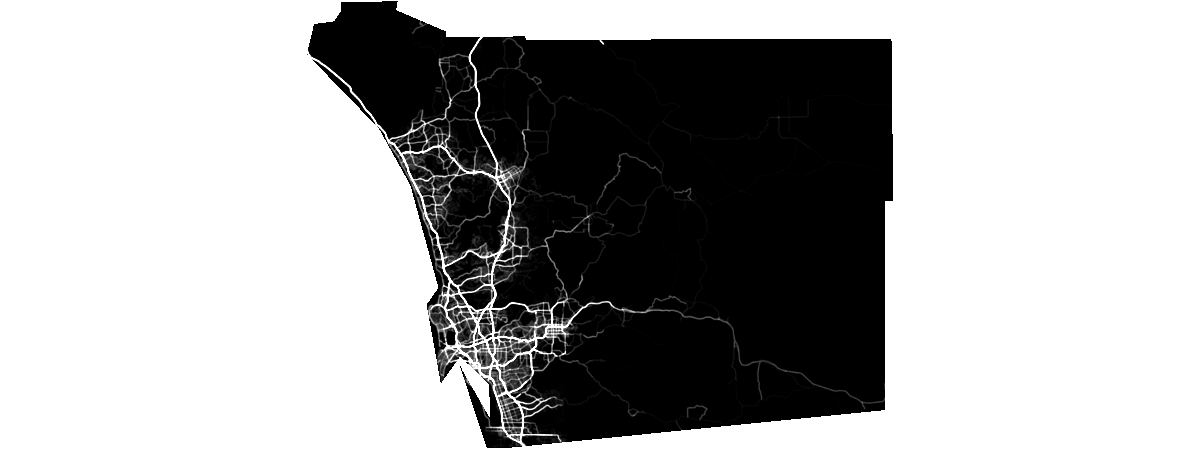

In [15]:
# USA traffic density layer: step 1 (clipping)

usa_roads.extent = study_area_extent
usa_roads_clip = clip(raster=usa_roads, geometry=study_area_geom)
stretch(raster=usa_roads_clip, stretch_type='StdDev', dra='true')

In [16]:
# Explore this map in a map widget
map_usa_roads = agol.map()
map_usa_roads.extent = {'spatialReference':{'latestwkid':3857, 'wkid':102100},
                    'xmax': -12899970.884006657,
                    'xmin': -13094557.353913298,
                    'ymax': 4016441.7785463207,
                    'ymin': 3784318.1781899934}          
map_usa_roads.legend = True
map_usa_roads.add_layer(stretch(raster=usa_roads_clip, stretch_type='StdDev', dra='true'))
map_usa_roads

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [17]:
# USA traffic density layer: step 2 (remap/normalize)

# st dev = 10778.479232322861

usa_roads_input_ranges_n = [0,10778.479232322861,
                      10778.479232322861, 10778.479232322861*2,
                      10778.479232322861*2, 10778.479232322861*3,
                      10778.479232322861*3, 998822/2,
                      998822/2, 998822]

usa_roads_n = remap(raster = usa_roads_clip,
               input_ranges = usa_roads_input_ranges_n,
               output_values = [i for i in range(5)],
               astype = 'U8')

usa_roads_n.extent = study_area_extent


In [18]:
# USA traffic density layer: step 3 (binarize)

# mean = 1174.8669998414075
# st dev = 10778.479232322861

usa_roads_b = remap(raster = usa_roads_clip,
                  input_ranges=[0, 1174.8669998414075 + 10778.479232322861, # the end is non-inclusive
                                1174.8669998414075 + 10778.479232322861, 998822],
                  output_values = [0, 1],  astype='U8')

usa_roads_b.extent = study_area_extent


Binarized Traffic Density


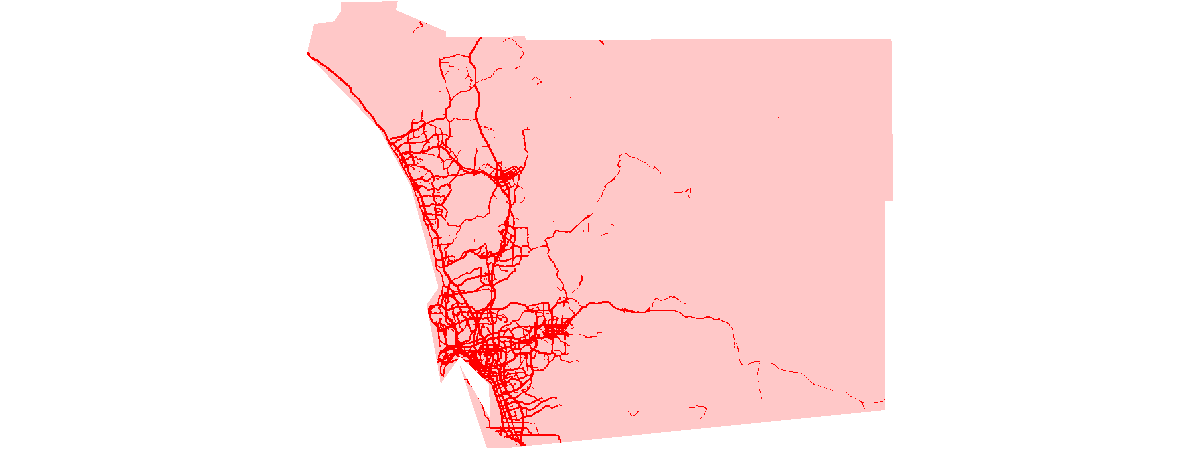

Normalized Traffic Density


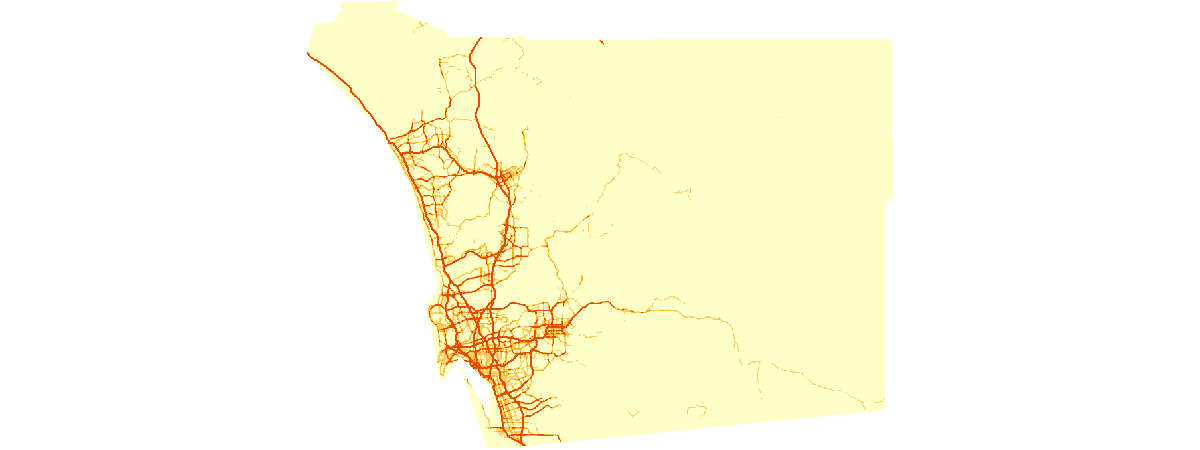

In [19]:
# USA traffic density layer: step 4 (visualize)

# binary
print("Binarized Traffic Density")
clrmap =   [[1, 255, 0, 0], [0, 255, 200, 200]]
usa_roads_b_c = colormap(raster=usa_roads_b, colormap=clrmap)
display(usa_roads_b_c)

# normalized
clrmap7 =  [[4, 153, 0, 0], [3, 230, 76, 0], [2, 255, 179, 25],[1, 255,204,102], [0, 255,255,200]]
print("Normalized Traffic Density")
usa_roads_n_c = colormap(raster = usa_roads_n, colormap = clrmap7)
display(usa_roads_n_c)

#### Preparation of the Population layer

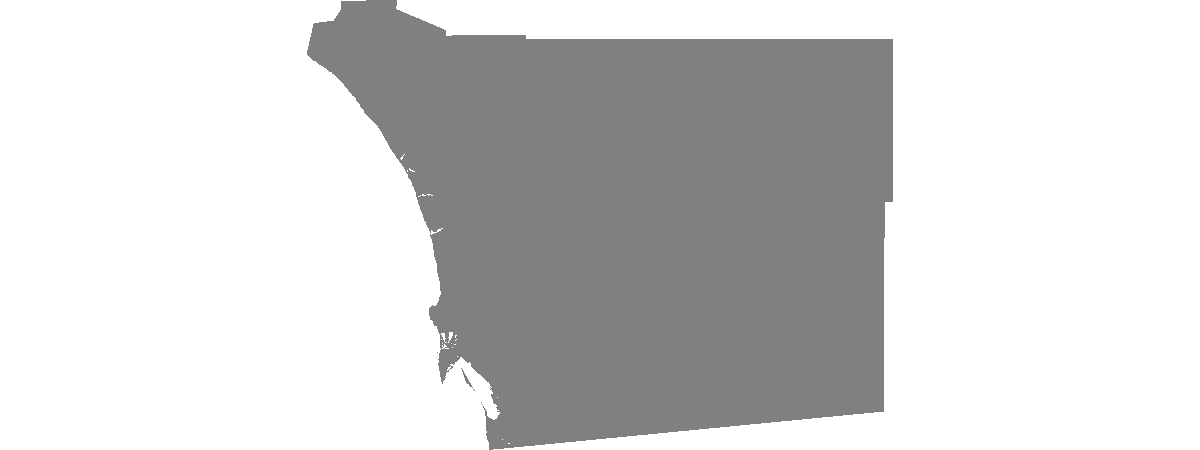

In [20]:
# Populations layer: step 1 (clipping)
populations_layer.extent = study_area_extent
populations_clip = clip(raster=populations_layer, geometry=study_area_geom) #Clip into study area
populations_clip

We're not sure why our clipped map shows up all grey so we also included a map widget of the non-clipped map. 

In [21]:
map_pop = agol.map()
map_pop.extent = {'spatialReference':{'latestwkid':3857, 'wkid':102100},
                    'xmax': -12899970.884006657,
                    'xmin': -13094557.353913298,
                    'ymax': 4016441.7785463207,
                    'ymin': 3784318.1781899934}          
map_pop.legend=True
map_pop.add_layer(populations_layer)
map_pop

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [22]:
# Populations layer: step 2 (remap/normalize)

# st dev = 583.7615877622886

pop_input_ranges_n = [0,583.7615877622886,
                      583.7615877622886, 583.7615877622886*2,
                      583.7615877622886*2, 583.7615877622886*3,
                      583.7615877622886*3, 823404/2,
                      823404/2, 823404]

pop_n = remap(raster = populations_clip,
               input_ranges = pop_input_ranges_n,
               output_values = [i for i in range(5)],
               astype = 'U8')

pop_n.extent= study_area_extent

In [23]:
# Populations layer: step 3 (binarize)

# mean = 31.54390069055915
# st dev = 583.7615877622886

pop_b = remap(raster = populations_clip,
                  input_ranges=[0, 31.54390069055915 + 583.7615877622886, # the end is non-inclusive
                                31.54390069055915 + 583.7615877622886, 823404],
                  output_values = [0, 1],  astype='U8')

pop_b.extent = study_area_extent


Binarized Population


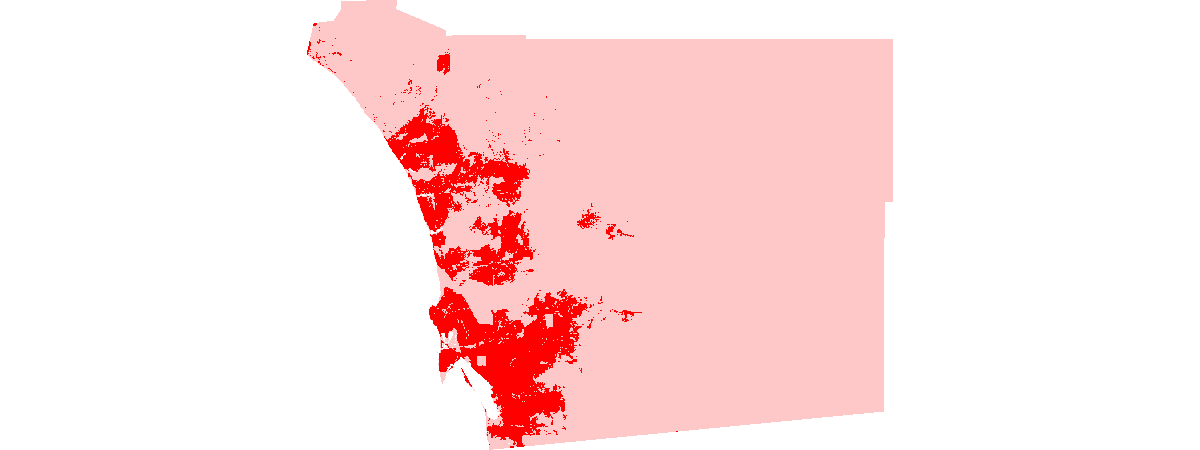

Normalized Population


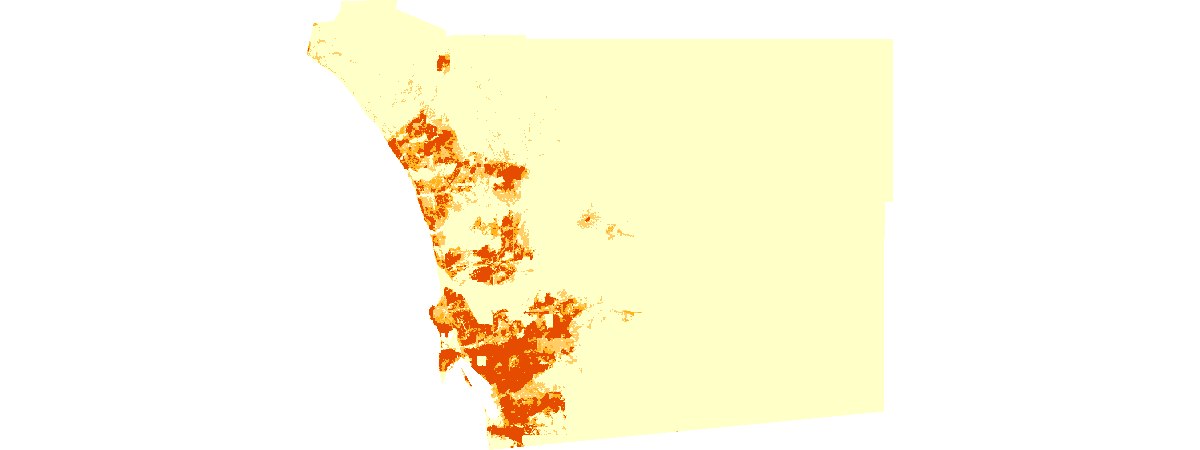

In [24]:
# Populations layer: step 4 (visualize)

# binary
print("Binarized Population")
pop_b_c = colormap(raster=pop_b, colormap=clrmap)
display(pop_b_c)

# normalized
print("Normalized Population")
populations_c = colormap(raster=pop_n, colormap=clrmap7)
populations_c

#### Preparation of the USA Land Use Layer

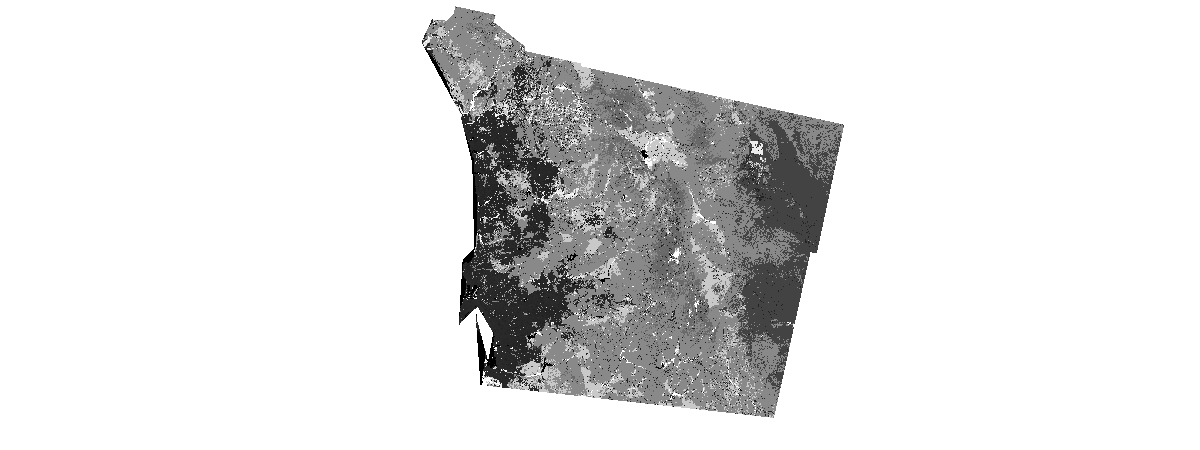

In [25]:
# USA land use: step 1 (clipping)

usa_land_use.extent = study_area_extent
land_use_clip = clip(raster = usa_land_use, geometry=study_area_geom)
stretch(raster=land_use_clip, stretch_type='StdDev', dra='true') 

In [26]:
# USA land use layer: step 2 (normalize)

land_use_input_ranges_n = [24, 25,
                           23, 24,
                           22, 23,
                           21, 22,
                           0, 21,
                           25, 95]

land_use_n = remap(raster = land_use_clip,
               input_ranges = land_use_input_ranges_n,
               output_values = [4,3,2,1,0,0],
               astype = 'U8')

land_use_n.extent= study_area_extent

For normalization, we weighted the lands based on how urbanized they were. Here is a more specific description of the land uses: 

21. _Developed, Open Space_ - areas with a mixture of some constructed materials, but mostly vegetation in the form of lawn grasses. Impervious surfaces account for less than 20% of total cover. These areas most commonly include large-lot single-family housing units, parks, golf courses, and vegetation planted in developed settings for recreation, erosion control, or aesthetic purposes.
22. _Developed, Low Intensity_ - areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 20% to 49% percent of total cover. These areas most commonly include single-family housing units.
23. _Developed, Medium Intensity_ - areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 50% to 79% of the total cover. These areas most commonly include single-family housing units.
24. _Developed High Intensity_ - highly developed areas where people reside or work in high numbers. Examples include apartment complexes, row houses and commercial/industrial. Impervious surfaces account for 80% to 100% of the total cover.

Every other type of land was given a value of zero since we don't want drive throughs in any of those locations.

In [27]:
# USA land use layer: step 3 (binarize)

land_use_b = remap(raster = land_use_clip,
                  input_ranges=[11, 24, # the end is non-inclusive
                                24, 25,
                                25, 95],
                  output_values = [0, 1, 0],  astype='U8')


Only areas with high intensity development were given a value of 1 when binarizing the layer. This is because the metadata indicates that this is the area "where people reside or work in high numbers". 

Binarized Land Use


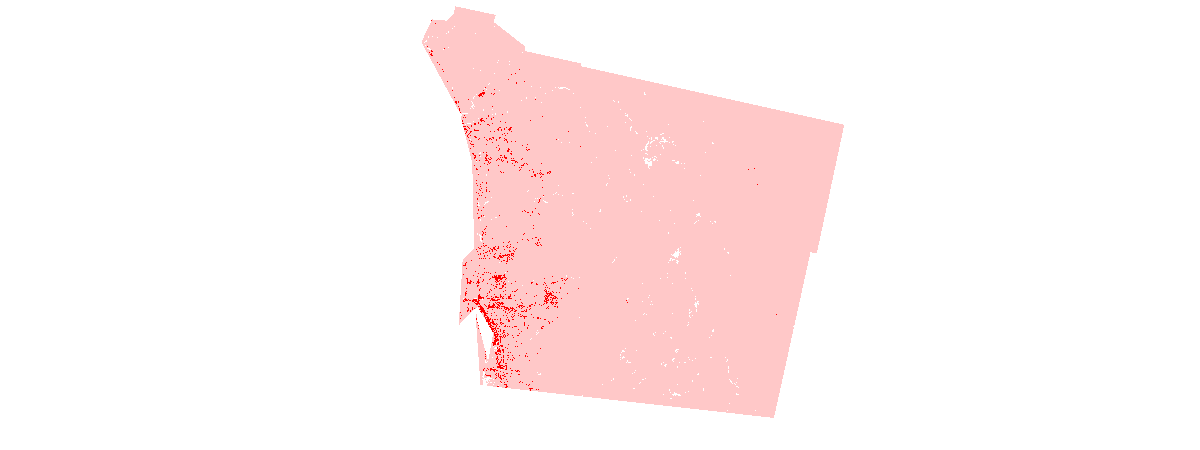

Normalized Land Use


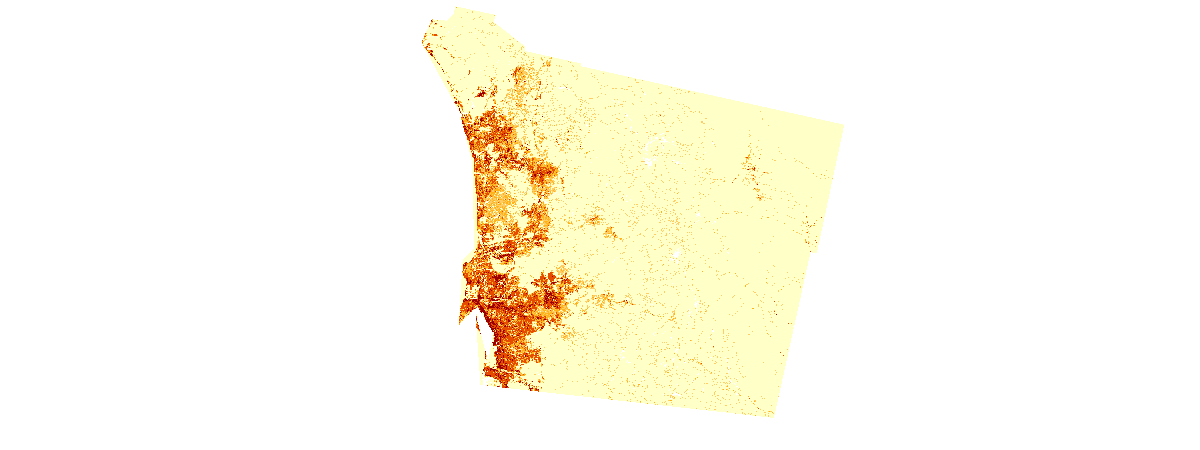

In [28]:
# USA land use layer: step 4 (visualize)

# binary
print("Binarized Land Use")
land_use_b_c = colormap(raster=land_use_b, colormap=clrmap)
display(land_use_b_c)

# normalized
print("Normalized Land Use")
land_use_n_c = colormap(raster=land_use_n, colormap=clrmap7)
display(land_use_n_c)


Exclusionary Screening Composite Layer


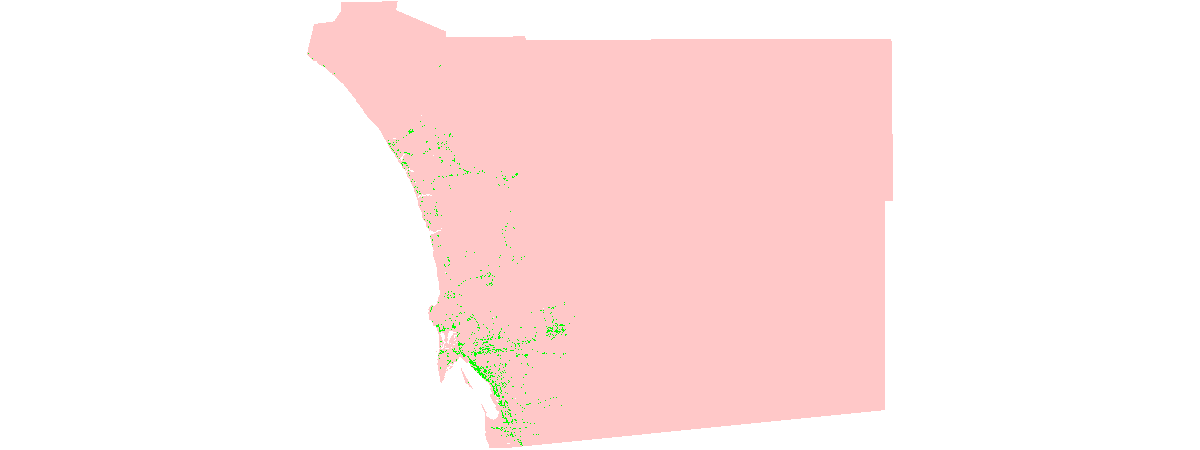

In [29]:
# 7a. Generate a composite raster layer for your first map combination technique

# exclusionary screening:
raster_calculator_output_es = raster_calculator(rasters = [usa_roads_b, pop_b, land_use_b], input_names = ["a","b","c"], expression = "a*b*c", extent_type='FirstOf', cellsize_type='FirstOf', astype=None)
raster_calculator_output_es = colormap(raster=raster_calculator_output_es, colormap=[[0, 255, 200, 200], [1, 0, 255, 0]])
print("Exclusionary Screening Composite Layer")
raster_calculator_output_es


#### Map Widget for 7a

In [78]:
map_7a = agol.map()
map_7a.extent = {'spatialReference':{'latestwkid':3857, 'wkid':102100},
                    'xmax': -12899970.884006657,
                    'xmin': -13094557.353913298,
                    'ymax': 4016441.7785463207,
                    'ymin': 3784318.1781899934}          
map_7a.legend=True
map_7a.add_layer(raster_calculator_output_es)
map_7a

MapView(layout=Layout(height='400px', width='100%'), legend=True)

Linear Combination Composite Layer


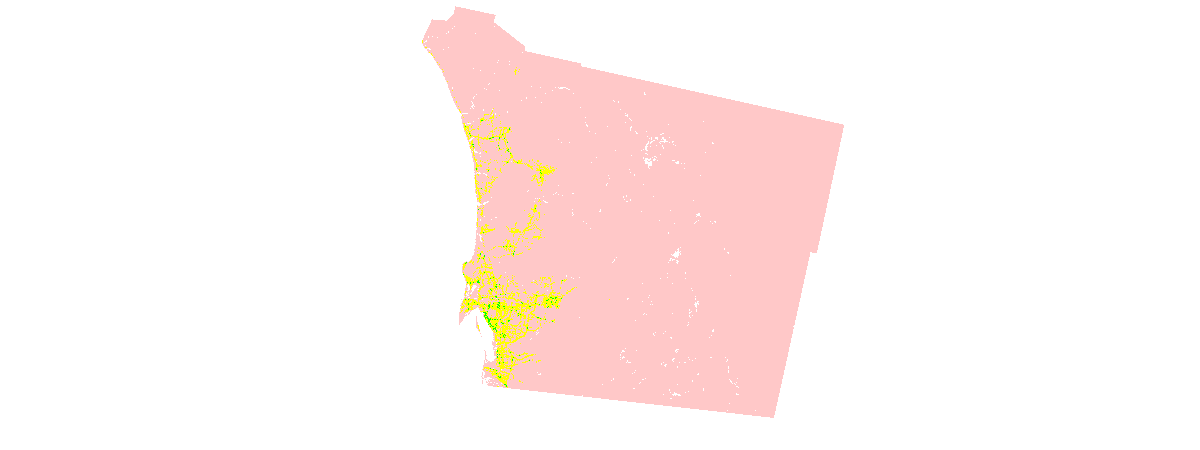

In [31]:
# 7b. Generate a composite raster layer for your second map combination technique

# Using Linear Combination mapping technique
result_lc = raster_calculator(rasters = [land_use_n, pop_n, usa_roads_n], input_names = ["a","b","c"], expression = "a + b + c", extent_type='FirstOf', cellsize_type='FirstOf', astype='none')

# let's remap the result into most suitable (9-15), moderately suitable (5-9), not suitable (0-5)
result_lc_n = remap(raster=result_lc,
                  input_ranges=[0.0,7.0, 7.00,9.15, 9.15,15.0],
                  output_values=[1,2,3],  astype='U8')

# Colorizing the map (Red = not suitable, Yellow = moderately suitable, Green = most suitable)
clrmap3 =  [[1, 255, 200, 200], [2, 255, 255, 0], [3, 0, 255, 0]]
result_lc_c = colormap(result_lc_n, colormap=clrmap3)
print("Linear Combination Composite Layer")
result_lc_c


#### Map Widget for 7b

In [32]:
map_7b = agol.map()
map_7b.extent = {'spatialReference':{'latestwkid':3857, 'wkid':102100},
                    'xmax': -12899970.884006657,
                    'xmin': -13094557.353913298,
                    'ymax': 4016441.7785463207,
                    'ymin': 3784318.1781899934}          
map_7b.legend=True
map_7b.add_layer(result_lc_c)
map_7b

MapView(layout=Layout(height='400px', width='100%'), legend=True)

Weight and Rate Composite Layer


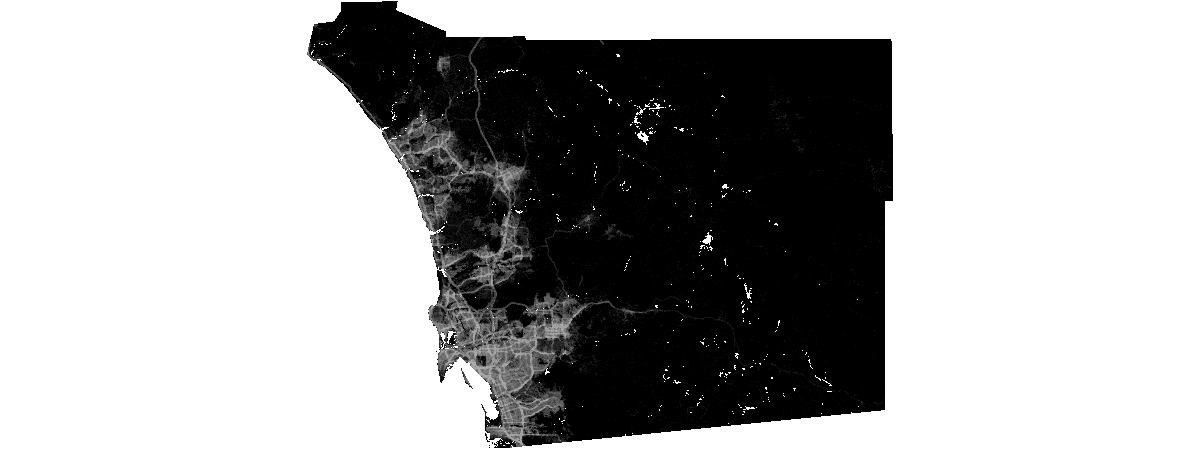

In [34]:
# 7c. Generate a composite raster layer for your third map combination technique

# weighting and rating:
weight_and_rate = raster_calculator(rasters = [usa_roads_n, pop_n, land_use_n], input_names = ["a","b","c"], expression = "a*.4 + b*.4 +c*.2", extent_type='FirstOf', cellsize_type='FirstOf', astype=None)
print("Weight and Rate Composite Layer")
stretch(raster=weight_and_rate, stretch_type='StdDev', dra='true')

We won't touch too much on this layer since the weights were very subjective, but this layer provides very optimal locations near roads with a higher traffic and population density. The lighter areas are more optimal locations whereas darker areas are less optimal. This layer looks very similar to our linear combination approach, however it's a little less granular. 

# 8. Compare the results, and describe how different combination techniques resulted in different outputs

__Results for 7A:__

For our first mapping combination technique, we decided to use the Exclusionary Screening approach. The reason we used this combination technique was because it's a simple technique that is easily implemented and the results of this combination technique is easily interpreted as well. To perform the exclusonary screening, we used the raster_calculator function that takes in as input the three binarized layers: the road layer, population density layer, and the land use layer, and get the product of their binarized values that will output a 1 if all three layers have a value of 1, or 0 otherwise (all or nothing outcome). The outcome of this layer combination is put into two simple categories: suitable (green) and not suitable (pink).

After visualizing our results to a map widget, we can see  that the combination technique output some green areas that are considered suitable and the rest are the not suitable areas in pink. The flaw of this model is that we are not able to get a thorough understanding of the results, we are restricted to only two categories, and we are also given too many options to choose a suitable location. The upside of using a technique such as Linear Combination in 7B is that we are able to get more categories in our output, to make more informed and better decisions for our drive through fast food locations.

__Results for 7B:__

For our second mapping combination technique, we decided to use a Linear Combination approach. To implement this, we used the raster_calculator function that takes in the three normalized layers: the road layer, population density layer, and the land use layer as input and sums up the layer values. Since we normalized all the layers into 5 different categories of suitability, each layer will have a value from either 0-5 with 0 being not suitable to 5 being the most suitable. The linear combination technique will combine the three layers and sum up the associated scores for every cell value of the layers to get a sum of suitability score that will range from 0 to 15. After we combined the three layers, we again want to normalize and remap our findings as well as colorize it to better interpret and visualize the results of the combination. To do this we have decided to output our results into three categories of suitability: not suitable (pink), moderately suitable (yellow), and most suitable (green). We created the range values for the sum of suitability score quite strictly, we decided that a score of 0-7 will simply not be a suitable area, a score of 7-9.15 is a moderately suitable area since this score means that the area meets some but not all of the requirements for a suitable drive through location (i.e, high population density with no popular roads nearby), and finally a score of 9.15-15 means that this area is the most suitable for a drive through fast food place to be built.

After visualizing our results to a map widget, we can look closely that there are a few selected areas that are placed in the 'most suitable' category which is what we want, because this gives us a more precise output than the exclusionary screening. We also can see that there are some selected areas marked as 'moderately suitable', this allows us to see which options are available to us in the case that we aren't able to build a drive through fast food place in a 'most suitable' area. The pros of using this linear combination model over the exclusionary screening is that we can customize our 'normalized ranges' for the categories in the combined layers to be how we want it to be, we could set the threshold score for the 'most suitable' to be higher if we wanted a more refined output and vice versa.

In [47]:
# concluding map

In [77]:
fast_food_layer = agol.content.get('e198b736fb734aa48a422b10d9ff2776')

conclusion_map = gis.map('San Diego County, CA')

clrmap3 =  [[1, 1, 1, 1], [2, 189, 188, 188], [3, 255, 255, 255]]
result_lc_c = colormap(result_lc_n, colormap=clrmap3)

conclusion_map.add_layer(result_lc_c)
conclusion_map.add_layer(fast_food_layer)
conclusion_map.legend = True
conclusion_map

MapView(layout=Layout(height='400px', width='100%'), legend=True)

We decided to see if our linear combination map matched up to locations of fast food restaurants already in SD county. We found a point layer of different fast food restaurants in SD ([link](https://ucsdonline.maps.arcgis.com/home/item.html?id=78ecf01334c94412a2c1e96c29a6df1e)) and put it on top of our linear combination raster layer. If you zoom in and look around, you can see that many restaurants already in SD are placed in our estimated most optimal locations, so that's a good sanity check that we found layers that helped us find good locations. 